In [1]:
# 读取数据
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('harmonic_oscillator_trajectory.csv')
x = data['x'].to_numpy()
y = data['p'].to_numpy()
N = x.shape[0]
data = np.vstack((x,y)).T
print(f'样本数量为{N}')



样本数量为10000


In [2]:
data_centered = data - np.mean(data,axis=0)
cov_matrix = np.cov(data_centered, rowvar=False)

# 确保协方差矩阵可逆
# 通过加一个小的正则化项来确保矩阵可逆（常用方法）
epsilon = 0 # 你可以调整这个值
cov_matrix += np.eye(cov_matrix.shape[0]) * epsilon

# 计算协方差矩阵的特征值和特征向量
eigvals, eigvecs = np.linalg.eigh(cov_matrix)

# 排序特征值和特征向量
sorted_indices = np.argsort(eigvals)[::-1]  # 从大到小排序
eigvals_sorted = eigvals[sorted_indices]
eigvecs_sorted = eigvecs[:, sorted_indices]

# 将数据投影到主成分上
data_pca = np.dot(data_centered, eigvecs_sorted)

# 白化：将特征值归一化，确保每个主成分的方差为 1
data_preprocessed = data_pca / np.sqrt(eigvals_sorted + epsilon)

print(eigvals_sorted)

[0.99386863 0.49127103]


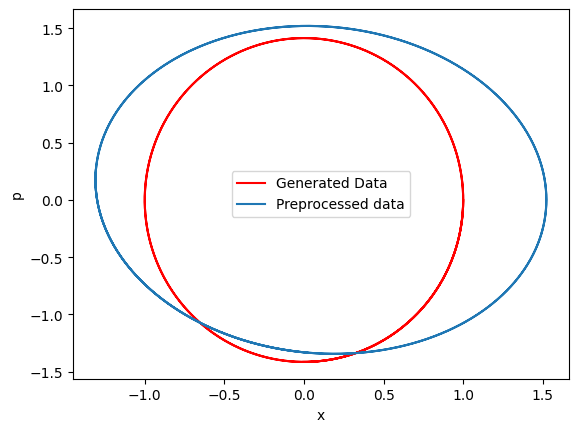

In [3]:
# 可视化数据
plt.plot(x, y, color='r', label="Generated Data")
plt.plot(data_preprocessed[:,0],data_preprocessed[:,1],label='Preprocessed data')


plt.xlabel("x")
plt.ylabel("p")
plt.legend()
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def adapted_sigmoid(x):
    return torch.sigmoid(x)*2-1
    
# 定义神经网络
class NLPCA(nn.Module):
    def __init__(self):
        super(NLPCA, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # 输入层到隐藏层
        self.fc2 = nn.Linear(64, 64)  # 隐藏层
        self.fc3 = nn.Linear(64, 1)   # 隐藏层到瓶颈层
        self.fc4 = nn.Linear(1,64)  # 瓶颈层到隐藏层
        self.fc5 = nn.Linear(64, 64)  # 隐藏层
        self.fc6 = nn.Linear(64, 2) #输出层
        

    def forward(self, x):
        x = adapted_sigmoid(self.fc1(x))  # ReLU激活函数
        x = adapted_sigmoid(self.fc2(x))
        x = self.fc3(x)  # 瓶颈层没有激活函数
        x = adapted_sigmoid(self.fc4(x))
        x = adapted_sigmoid(self.fc5(x))
        x = self.fc6(x)
        return x
    
model = NLPCA()
criterion = nn.MSELoss()  # 对于回归问题，通常使用均方误差（MSE）损失
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000  # 训练的轮次

# 准备训练数据
data_tensor = torch.tensor(data_preprocessed,dtype=torch.float32)
dataset = TensorDataset(data_tensor, data_tensor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# 训练神经网络
num_epochs = 1000  # 训练的轮次
loss_list = []

for epoch in range(num_epochs):
    model.train()  # 设置为训练模式
    running_loss = 0.0

    # 训练阶段
    for inputs, targets in data_loader:
        optimizer.zero_grad()  # 清除梯度
        outputs = model(inputs)  # 前向传播
        loss = criterion(outputs, targets)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数

        running_loss += loss.item() 
    
        # 在每个 epoch 结束后计算训练损失
    avg_loss = running_loss / len(data_loader)
    loss_list.append(avg_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/1000], Loss: 0.5489
Epoch [2/1000], Loss: 0.5020
Epoch [3/1000], Loss: 0.5018
Epoch [4/1000], Loss: 0.5020
Epoch [5/1000], Loss: 0.5009
Epoch [6/1000], Loss: 0.5015
Epoch [7/1000], Loss: 0.5008
Epoch [8/1000], Loss: 0.5011
Epoch [9/1000], Loss: 0.5007
Epoch [10/1000], Loss: 0.5008
Epoch [11/1000], Loss: 0.5007
Epoch [12/1000], Loss: 0.5007
Epoch [13/1000], Loss: 0.5009
Epoch [14/1000], Loss: 0.5008
Epoch [15/1000], Loss: 0.5005
Epoch [16/1000], Loss: 0.5008
Epoch [17/1000], Loss: 0.5006
Epoch [18/1000], Loss: 0.5007
Epoch [19/1000], Loss: 0.5005
Epoch [20/1000], Loss: 0.5006
Epoch [21/1000], Loss: 0.5008
Epoch [22/1000], Loss: 0.5006
Epoch [23/1000], Loss: 0.5008
Epoch [24/1000], Loss: 0.5006
Epoch [25/1000], Loss: 0.5010
Epoch [26/1000], Loss: 0.5007
Epoch [27/1000], Loss: 0.5012
Epoch [28/1000], Loss: 0.5007
Epoch [29/1000], Loss: 0.5007
Epoch [30/1000], Loss: 0.5006
Epoch [31/1000], Loss: 0.5004
Epoch [32/1000], Loss: 0.5003
Epoch [33/1000], Loss: 0.5004
Epoch [34/1000], Lo

C:\Users\ASUS\AppData\Local\Temp\ipykernel_31200\474634221.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


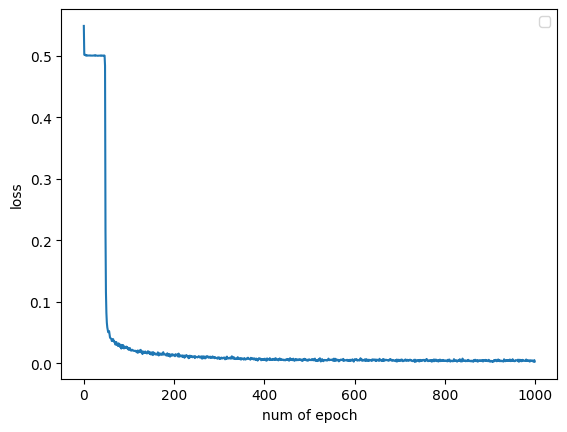

In [9]:
plt.plot(np.arange(num_epochs),loss_list)
plt.legend()
plt.xlabel('num of epoch')
plt.ylabel('loss')

plt.show()